## Tutorial: Mixture Density Networks with JAX ##

April 2020

Related posts:
- JavaScript [Tutorial](http://blog.otoro.net/2015/06/14/mixture-density-networks/)
- TensorFlow [Tutorial](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/)
- PyTorch [Tuturial](https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb)

*Note: This notebook used a slightly different loss formulation that is more efficient compared to the previous tutorials.*

JAX is a minimal framework to automatically calculate the gradients of native Python and NumPy / SciPy functions. It is a nice tool in the machine learning research toolbox.

Recommended [JAX](https://github.com/google/jax/) Tutorials: [Getting started with JAX](https://roberttlange.github.io/posts/2020/03/blog-post-10/) and [You don't know JAX](https://colinraffel.com/blog/you-don-t-know-jax.html)

## Background: Standard Data Fitting ##

Before we talk about Mixture Density Networks, let's perform some standard data fitting using NumPy/JAX to make sure everything works.

Neural nets with even one hidden layer can be universal function approximators, so let's try to fit a sinusoidal function.

$y_{true}(x)=7 \sin( 0.75 x ) + 0.5 x + \epsilon$

- $y_{true}(x)$: this function $y_{true}$ takes $x$ as input.
- $7 \sin( 0.75 x)$: a large periodic $\sin$ wave.
- $0.5 x$: add a slight upward slope.
- $\epsilon$: add some random noise "epsilon".

First we import the [JAX](https://github.com/google/jax/) and NumPy libraries we need.

In [1]:
import matplotlib.pyplot as plt # creating visualizations
import numpy as onp # we still need original nump for some tasks

In [2]:
import jax.numpy as np # JAX is supposed to have an API that closely resemble NumPy's
from jax import grad, jit, vmap, value_and_grad
from jax import random

In [3]:
from jax.experimental import optimizers

Then we generate random inputs $x$ to get random samples of $y(x)$. Later we will train a neural net on this data.

Note that we will generate 1000 datapoints and treat the entire dataset as one large batch.

In [4]:
# Generate key which is used to generate random numbers
key = random.PRNGKey(777)

In [5]:
def generate_data(n_samples):
  epsilon = onp.random.normal(size=(n_samples))
  x_data = onp.random.uniform(-10.5, 10.5, n_samples)
  y_data = 7*np.sin(0.75*x_data) + 0.5*x_data + epsilon
  return x_data, y_data
  
n_samples = batch_size = 1000 # just use train everything in a batch
x_data, y_data = generate_data(n_samples)
x_data = np.array(x_data.reshape(batch_size, 1))
y_data = np.array(y_data.reshape(batch_size, 1))

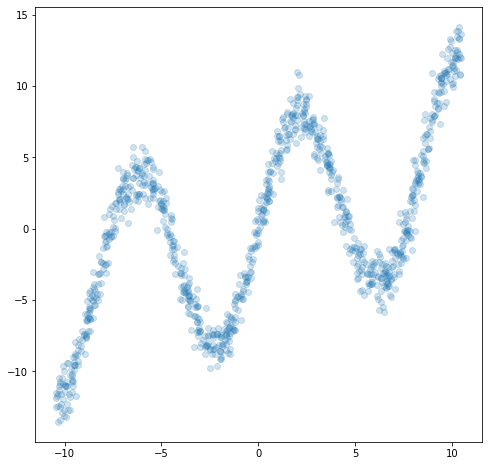

In [6]:
plt.figure(figsize=(8, 8))
plt.scatter(x_data, y_data, alpha=0.2)
plt.show()

We will use this data to train a neural network with one hidden layer. This neural network is described by the following equation:

$y_{pred}(x) = w_{out} \tanh( w_{in} x + b_{in}) + b_{out}$

- $y_{pred}(x)$: this function $y_{pred}$ takes $x$ as input.
- $w_{in}, w_{out}$: weights for the input and output layers.
- $b_{in}, b_{out}$: biases for the input and output layers.
- $\tanh$: a nonlinear activation function.

Let's create this network using 20 hidden nodes.

In [7]:
n_input = 1
n_hidden = 20
n_output = 1

While `initialize_mlp` and `network` can be done cleanly with [stax](https://github.com/google/jax/blob/master/jax/experimental/stax.py), and stuff can work faster with vmap / jit, but for the purposes of this tutorial, I just want to do it in raw NumPy syntax to make sure JAX works as advertised.

In [8]:
def initialize_mlp(sizes, key):
  """ Initialize the weights of all layers of a linear layer network """
  """ (taken from https://roberttlange.github.io/posts/2020/03/blog-post-10/) """
  keys = random.split(key, len(sizes))
  # Initialize a single layer with Gaussian weights -  helper function
  def initialize_layer(m, n, key, scale=1e-2):
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
  return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [n_input, n_hidden, n_output]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

In [9]:
def network(params, inputs):
  """ Feed forward Tanh MLP network using params """
  h = inputs
  for idx, param in enumerate(params[:-1]):
    w = param[0]
    b = param[1]
    h = np.tanh(np.dot(h, w.T) + b)
  param = params[-1]
  w = param[0]
  b = param[1]
  return np.dot(h, w.T) + b

To train the network we must define a loss function. We will use the [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) loss function.

In [10]:
def loss_fn(params, model, inputs, targets):
  predictions = model(params, inputs)
  errors = predictions-targets
  return np.average(np.square(errors))

We will use the Adam optimizer that JAX comes with:

In [11]:
step_size = 0.01
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

Now let's define the update rule and the training loop. It will use JAX to find both the loss value and gradient of the loss function at the current model parameters, and the optimizer will use the gradient to find a better set of parameters:

In [12]:
def update(params, model, inputs, targets, opt_state):
  """ Compute the gradient for a batch and update the parameters """
  """ (taken from https://roberttlange.github.io/posts/2020/03/blog-post-10/) """
  value, grads = value_and_grad(loss_fn)(params, model, inputs, targets)
  opt_state = opt_update(0, grads, opt_state)
  return get_params(opt_state), opt_state, value

In [13]:
def train(params, network, x_data, y_data, opt_state):
  for epoch in range(3000):
    params, opt_state, loss = update(params, network, x_data, y_data, opt_state)
    if epoch % 300 == 0:
      print(epoch, loss)
  return params

params = train(params, network, x_data, y_data, opt_state)

0 36.576805
300 15.698829
600 5.840685
900 2.7655978
1200 1.6917064
1500 1.2692212
1800 1.1060889
2100 1.044864
2400 1.0190339
2700 1.0034635


Let's see how it performs by processing some evenly spaced samples.

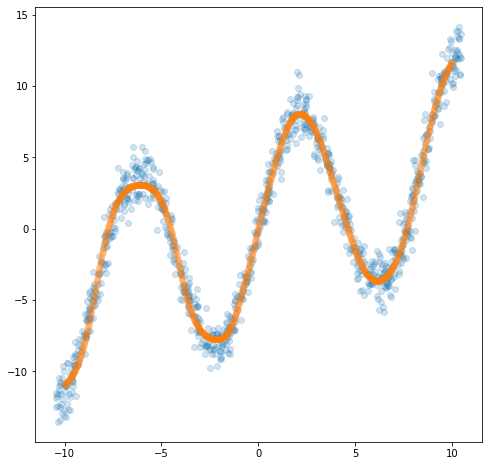

In [14]:
# evenly spaced samples from -10 to 10
x_test_data = onp.linspace(-10, 10, n_samples).reshape(batch_size, 1)

# move from torch back to numpy
y_test_data = network(params, x_test_data)

# plot the original data and the test data
plt.figure(figsize=(8, 8))
plt.scatter(x_data, y_data, alpha=0.2)
plt.scatter(x_test_data, y_test_data, alpha=0.2)
plt.show()

The network can fit this sinusoidal data quite well, as expected. However, this type of fitting only when we want to approximate a one-to-one, or many-to-one relationship.

Suppose we invert the training data so we are predicting $x(y)$ instead of $y(x)$.

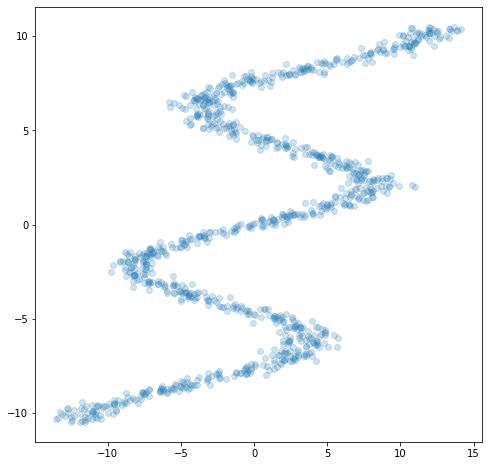

In [15]:
# plot x against y instead of y against x
plt.figure(figsize=(8, 8))
plt.scatter(y_data, x_data, alpha=0.2)
plt.show()

If we use the same method to fit this data, it won't work well because the network can't output multiple values for each input. Because we used mean squared error loss, the network will try to output the average output value for each input.

In [16]:
params = initialize_mlp(layer_sizes, key)

# swap x and y axes:
mdn_x_data = y_data
mdn_y_data = x_data

params = train(params, network, mdn_x_data, mdn_y_data, opt_state)

0 37.73501
300 21.905428
600 21.338938
900 21.195051
1200 21.118862
1500 21.0495
1800 20.961632
2100 20.873568
2400 20.808044
2700 20.752817


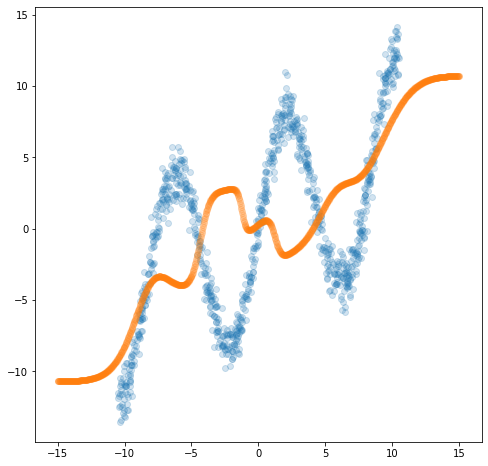

In [17]:
# evenly spaced samples from -15 to 15
x_test_data = onp.linspace(-15, 15, n_samples).reshape(batch_size, 1)

# move from torch back to numpy
y_test_data = network(params, x_test_data)

# plot the original data and the test data
plt.figure(figsize=(8, 8))
plt.scatter(x_data, y_data, alpha=0.2)
plt.scatter(x_test_data, y_test_data, alpha=0.2)
plt.show()

Because our network only predicts one output value for each input, this approach will fail miserably.

What we want is a network that has the ability to predict a multiple output values for each input. In the next section we implement a Mixture Density Network (MDN) to achieve this task.

## Mixture Density Networks ##

Mixture Density Networks ([Bishop](https://publications.aston.ac.uk/id/eprint/373/1/NCRG_94_004.pdf)), developed Chris Bishop in the 1990s, are one way to produce multiple outputs from a single input. MDN predicts a *probability distribution* of possible output values, and assumes that this distribution is a mixture of weighted probability distributions, thus making it possible to sample several possible different output values for a particular given input. This concept is quite powerful, and can be employed many current areas of machine learning research.

The inverted sinusoid data we chose is not just a toy problem. In [the paper introducing MDNs](http://publications.aston.ac.uk/373/1/NCRG_94_004.pdf) an inverted sinusoid is used to describe the angle we need to move a robot arm to achieve a target location. MDNs are also used to model handwriting, where the next stroke is drawn from a probability distribution of multiple possibilities, rather than sticking to one prediction.

Bishop's implementation of MDNs will predict a class of probability distributions called mixture of Gaussians, where the output value is modelled as a weighted sum of multiple Gaussians, each with different means and standard deviations.

So for each input $x$, we will predict a probability distribution function $P(Y=y|X=x) = \sum_{i}^{K} \Pi_{i}(x) \phi(y, \mu_{i}(x), \sigma_{i}(x))$

- $i$ is an index describing which Gaussian we are referencing. There are $K$ Gaussians total.
- $\sum_{i}^{K}$ is the summation operator. We sum every $i$ Gaussian across all $K$. You might also see $\sum_{i=0}^{K-1}$ or $\sum_{i=1}^{K}$ depending on whether an author is using zero-based numbering or not.
- $\Pi_i$ acts as a weight, or multiplier, for mixing every $i$ Gaussian. It is a function of the input $x$: $\Pi_i(x)$
- $\mu_i$ and $\sigma_i$ are the parameters for the $i$ Gaussian: mean $\mu_i$ and standard deviation $\sigma_i$. Instead of being fixed for each Gaussian, they are also functions of the input $x$: $\mu_i(x)$ and $\sigma_i(x)$
- $\phi$ is the Gaussian function and returns the at $y$ for a given mean and standard deviation. $\phi(y, \mu, \sigma) = \frac{1}{\sigma \sqrt{2\pi}} \exp(-\frac{1}{2}(\frac{y-\mu}{\sigma})^2)$

All of $\sigma_{i}$ are positive, and all of the weights $\Pi$ must sum to one: $\sum_{i}^{K} \Pi_{i} = 1$

First our network must learn the functions $\Pi_{i}(x), \mu_{i}(x), \sigma_{i}(x)$ for every $i$ Gaussian. Then these functions can be used to generate individual parameters $\mu_i, \sigma_i, \Pi_i$ for a given input $x$. These parameters will be used to generate our pdf $P(Y=y|X=x)$. Finally, to make a prediction, we will need to sample (pick a value) from this pdf.

In our toy implementation, we will use a neural network of one hidden layer with 20 nodes. This will feed into another layer that generates the parameters for 5 mixtures: with 3 parameters $\Pi_i$, $\mu_i$, $\sigma_i$ for each Gaussian $i$. Our definition will be split into three parts.

First we will compute 20 hidden values $z_h$ from our input $x$: $z_h(x) = \tanh( W_{in} x + b_{in})$

Second, we will use these hidden values $z_h$ to compute our three sets of parameters $\Pi, \sigma, \mu$:

$
z_\Pi = W_{\Pi} z_h + b_{\Pi}\\
z_\sigma = W_{\sigma} z_h + b_{\sigma}\\
z_\mu = W_{\mu} z_h + b_{\mu}
$

Note that in practice, our network's output layer will be one large vector containing all $(z_\Pi, z_\sigma, z\mu)$, and these 3 vectors then be split accordingly.

Third, we will use the output of these layers to determine the parameters of the mixture of Gaussian distributions that can be used for sampling. Note that there are no learnable parameters in this transformation, and as we will see later, the loss function will be performed on $z$'s, before the transformation, for efficiency and optimization stability.

$
\Pi_i = \frac{\exp(z_{\Pi_i})}{\sum_{j}^{K} \exp(z_{\Pi_j})}\\
\sigma_i = \exp(z_{\sigma_i})\\
\mu_i = z_{\mu_i}
$

- $\exp(x)$ is the exponential function also written as $e^x$

We use a [*softmax*](https://en.wikipedia.org/wiki/Softmax_function) operator to ensure that $\Pi_i$ sums to one across all $i$, and the exponential function ensures that each weight $\Pi_i$ is positive. We also use the exponential function to ensure that every $\sigma_i$ is positive.

Let's define our MDN, and also its loss function, in JAX (using stax to help code up the network with less code):

In [29]:
# using stax, much cleaner
from jax.experimental import stax
from jax.scipy.special import logsumexp # Compute the log of the sum of exponentials of input elements
from jax.nn import softmax # pretty much the same as the interface as the one in scipy.special

from jax.experimental.stax import (Dense, Tanh, Flatten, Relu, LogSoftmax, Softmax, Exp)

We cannot use the mean square loss function for this task, because the output is an entire description of the probability distribution and not just a single value. A more suitable function to optimize for is to maximize the logarithm of the likelihood of the output distribution vs the training data, or equivalently minimize the negative log likelihood of the distribution vs data:

$loss(Y = y | X = x) = -\log\left( P(Y = y | X = x )\right)$

$loss(Y = y | X = x) = -\log\left( \sum_{i}^{K} \Pi_{i}(x) \phi(y, \mu_{i}(x), \sigma_{i}(x)) \right)$

Where $\phi(y, \mu_{i}(x), \sigma_{i}(x))$ is the normal distribution.

So for every $x$ input and $y$ output pair in the training data set, we can compute a loss based on the predicted distribution versus the actual distribution, and then attempt the minimise the sum of all the costs combined. To those who are familiar with logistic regression and cross entropy minimisation of softmax, this is a similar approach, but with non-discretised states. We have to implement this cost function ourselves.

**Note** that unlike previous versions of this tutorials (in JavaScript, TensorFlow, PyTorch), we will define the loss function log space (via `logsumexp`) for efficiency and stability. This greatly helps the training of complex networks that incorporates an MDN layer as part of the architecture.

Recall that the softmax function for classification problems is defined as $P(Y = i) = \frac{\exp(z_{\Pi_i})}{\sum_{j=1}^{K} \exp(z_{\Pi_j})}$ for $K$ different classes, where $z_{\Pi_i}(x)$ is the logits for the particular class.

In practice, you are not going to define the loss function as the logarithm of an exponential, and you may have learned from introduction books on deep learning about efficient implementation of softmax, and aso the log of softmaxl that avoids numerical instabilities.

For the case of the softmax, $\log\left(P(Y = i)\right)$ is $\log\left(\frac{\exp(z_{\Pi_i})}{\sum_{j}^{K} \exp(z_{\Pi_j}})\right)$ which can be written as $\log\left(\exp(z_{\Pi_i})\right) - \log\left(\sum_{j}^{K} \exp(z_{\Pi_j})\right)$ and simplified to:

$\log\left(P(Y = i)\right) = z_{\Pi_i} - log\left(\sum_{j}^{K} \exp(z_{\Pi_j})\right)$

The functional form on the right, $\log\left(\sum_{j}^{K} e^{z_j}\right)$, is implemented efficienctly as a `logsumexp` function in most frameworks (including numpy/scipy and JAX), and we can try to get our loss function to call the more efficient `logsumexp(z)` in the code:

In [19]:
# Let's create our MDN with 20 hidden nodes (n_hidden) and 5 Gaussians.

n_mixture = 5

# get output from network
init_fun, network = stax.serial(Dense(n_hidden), Tanh, Dense(n_mixture*3))

logSqrtTwoPI = onp.log(onp.sqrt(2.0 * onp.pi))

def lognormal(y, mean, logstd):
  return -0.5 * ((y - mean) / np.exp(logstd)) ** 2 - logstd - logSqrtTwoPI

def get_mdn_coef(output):
  logmix, mean, logstd = output.split(3, axis=1)
  logmix = logmix - logsumexp(logmix, 1, keepdims=True)
  return logmix, mean, logstd

def mdn_loss_func(logmix, mean, logstd, y):
  v = logmix + lognormal(y, mean, logstd)
  v = logsumexp(v, axis=1)
  return -np.mean(v)

_, params = init_fun(key, (batch_size, 1))

Let us explain what we have done here.

Recall our $loss(Y = y | X = x) = -\log\left( \sum_{i}^{K} \Pi_{i}(x) \phi(y, \mu_{i}(x), \sigma_{i}(x)) \right)$

Where $\phi(y, \mu_{i}(x), \sigma_{i}(x))$ is the normal distribution:

$\phi(y, \mu, \sigma) = \frac{1}{\sigma \sqrt{2\pi}} \exp(-\frac{1}{2}(\frac{y-\mu}{\sigma})^2)$

And after a bit of manipulation, like what we have done for the simpler softmax example earlier, it can be written as:

$loss(Y = y | X = x) = -\log\left( \sum_{i}^{K} \Pi_{i}(x) \phi(y, \mu_{i}(x), \sigma_{i}(x)) \right)$

$loss(Y = y | X = x) = -\log\left( \sum_{i}^{K} \frac{\exp(z_{\Pi_i})}{\sum_{j}^{K} \exp(z_{\Pi_j})} \frac{1}{\sigma_i \sqrt{2\pi}} \exp(-\frac{1}{2}(\frac{y-\mu_i}{\sigma_i})^2) \right)$

(dependencies on $x$ omitted for brevity.)

$loss(Y = y | X = x) = -\log\left( \sum_{i}^{K} \exp\left( \log\left( \frac{\exp(z_{\Pi_i})}{\sum_{j}^{K} \exp(z_{\Pi_j})} \frac{1}{\sigma_i \sqrt{2\pi}} \exp(-\frac{1}{2}(\frac{y-\mu_i}{\sigma_i})^2)\right)\right) \right)$

$loss(Y = y | X = x) = -\log\left( \sum_{i}^{K} \exp( F(x) ) \right) = - \texttt{logsumexp}\left(F(x)\right)$

that can be implemented with `logsumexp(F)` where `F(x)` is an intermediate expression:

$F(x) = \log( \frac{\exp(z_{\Pi_i})}{\sum_{j}^{K} \exp(z_{\Pi_j})} \frac{1}{\sigma_i \sqrt{2\pi}} \exp(-\frac{1}{2}(\frac{y-\mu_i}{\sigma_i})^2))$

$F(x) = z_{\Pi_i} - \log( \sum_{j}^{K} \exp(z_{\Pi_j}) - \log(\sigma_i) - \log\sqrt{2\pi} -\frac{1}{2}(\frac{y-\mu_i}{\sigma_i})^2$

And simplified to largely using logits $z(x)$'s:

$F(x) = z_{\Pi_i}(x) - \log( \sum_{j}^{K} \exp(z_{\Pi_j}(x)) - z_{\sigma_i}(x) - \log\sqrt{2\pi} -\frac{1}{2}\left(\frac{y-\mu_i(x)}{\exp(z_{\sigma_i}(x))}\right)^2$

$F(x) = z_{\Pi_i}(x) - \texttt{logsumexp}(z_{\Pi_j}(x)) - z_{\sigma_i}(x) - \log\sqrt{2\pi} -\frac{1}{2}\left(\frac{y-\mu_i(x)}{\exp(z_{\sigma_i}(x))}\right)^2$

So the entire loss function is implemented as:

$loss(Y = y | X = x) = - \texttt{logsumexp}\left( z_{\Pi_i}(x) - \texttt{logsumexp}(z_{\Pi_j}(x)) - z_{\sigma_i}(x) - \log\sqrt{2\pi} -\frac{1}{2}\left(\frac{y-\mu_i(x)}{\exp(z_{\sigma_i}(x))}\right)^2 \right)$

While for the purpose of the toy example in this notebook, it doesn't really matter whether we use the efficient implementation, but in practice, I found that this version of the MDN is vastly more stable than the simpler version, results in fewer NaN's, and I have used this variation in many research projects such as modeling [Kanji](https://arxiv.org/abs/1812.01718), [Vector Graphics](https://arxiv.org/abs/1904.02632), and [World Models](https://worldmodels.github.io/).

In [20]:
def loss_fn(params, model, inputs, targets):
  """ MDN Loss function for training loop. """
  outputs = network(params, inputs)
  logmix, mean, logstd = get_mdn_coef(outputs)
  return mdn_loss_func(logmix, mean, logstd, targets)

In [21]:
step_size = 0.01
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

In [22]:
params = train(params, network, mdn_x_data, mdn_y_data, opt_state)

0 5.935541
300 2.1405284
600 1.85367
900 1.7618631
1200 1.5921192
1500 1.3645843
1800 1.3207716
2100 1.2992609
2400 1.2890443
2700 1.2824807


Once the training is finished, we can observe all the parameters for the Gaussians and see how they vary with respect to the input $x$.

As previously noted, the output from `network` are in log space, and we will need to convert them into the usable numbers we need for sampling later, using `softmax` and `exp` functions.

In [23]:
logmix, mu_data, logstd = get_mdn_coef(network(params, x_test_data))
pi_data = softmax(logmix)
sigma_data = np.exp(logstd)

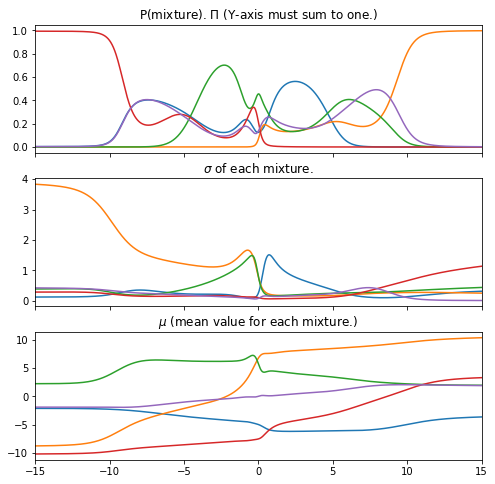

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,8))
ax1.plot(x_test_data, pi_data)
ax1.set_title('P(mixture). $\Pi$ (Y-axis must sum to one.)')
ax2.plot(x_test_data, sigma_data)
ax2.set_title('$\sigma$ of each mixture.')
ax3.plot(x_test_data, mu_data)
ax3.set_title('$\mu$ (mean value for each mixture.)')
plt.xlim([-15,15])
plt.show()

We can also plot the $\mu$ of each Gaussian with respect to $x$, and show the range of by highlighting a region between $\mu-\sigma$ and $\mu+\sigma$.

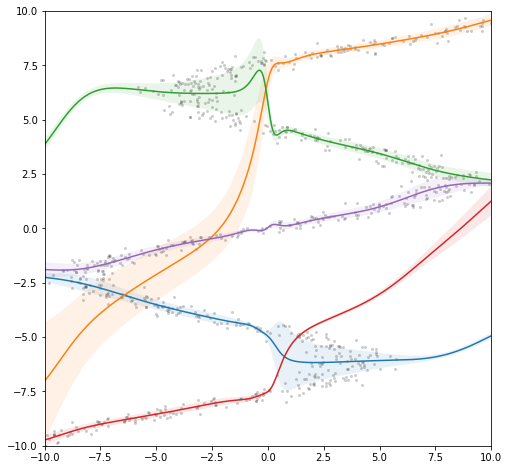

In [25]:
plt.figure(figsize=(8, 8), facecolor='white')
for mu_k, sigma_k in zip(mu_data.T, sigma_data.T):
    plt.plot(x_test_data, mu_k)
    plt.fill_between(x_test_data.flatten(), mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)
plt.scatter(mdn_x_data, mdn_y_data, marker='.', lw=0, alpha=0.2, c='black')
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.show()

In the plot above, we see that for every point on the $x$-axis, there are multiple lines or states where $y$ may be, and we select these states with probabilities modelled by $\Pi$. Note that the network won't find an ideal solution every time. It's possible to get lower loss by using more Gaussians, but the results are harder to interpret.

If we want to sample from the network we will need to pick a Gaussian $k$ and pick a value (sample) from that Gaussian. Here we use a trick called [Gumbel softmax sampling](http://timvieira.github.io/blog/post/2014/07/31/gumbel-max-trick/) to pick our $k$. We treat the $\Pi$ weights as a discrete distribution of probabilities, and sample one $k$ for each row of `pi_data`.

In [26]:
def gumbel_sample(x, axis=1):
  z = onp.random.gumbel(loc=0, scale=1, size=x.shape)
  return (onp.log(x) + z).argmax(axis=axis)

k = gumbel_sample(pi_data)

Now that we have selected $k$ for each row, we can select $\sigma$ and $\mu$ as well. We will use `onp.random.randn` to sample from each Gaussian, scaling it by $\sigma$ and offsetting it by $\mu$.

In [27]:
indices = (onp.arange(n_samples), k)
rn = onp.random.randn(n_samples)
sampled = rn * sigma_data[indices] + mu_data[indices]

With these sampled $y$ values, we can overlay them on the original distribution to see how accurately the network captures the shape.

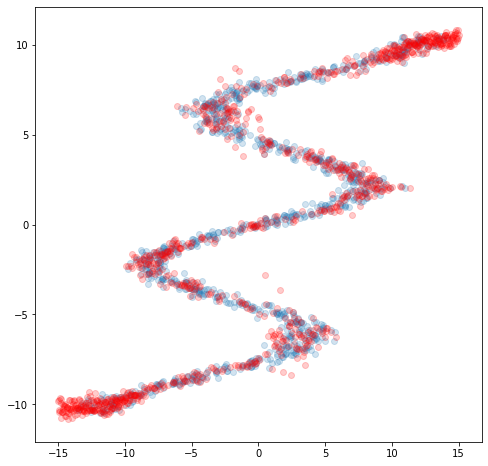

In [28]:
plt.figure(figsize=(8, 8))
plt.scatter(mdn_x_data, mdn_y_data, alpha=0.2)
plt.scatter(x_test_data, sampled, alpha=0.2, color='red')
plt.show()

Some other things to try:
    
- What other constraints might we enforce? Is it ever helpful to encourage $\Pi$ to be sparse to maintain a "simple" distribution?
- What kinds of regularization can we add to the network?
- Often very small sigma can create problems, it might be helpful to add `sigma += 0.01` inside the MDN.
- How do more or fewer Gaussians affect the result?
- How do more or fewer hidden nodes affect the result?
- What other kinds of nonlinear activation functions work besides `Tanh()`? Try `Sigmoid()` too.
- How do these plots move if you draw them in realtime while the network is training?
- What happens when if you use the [*softplus*](https://en.wikipedia.org/wiki/Softplus) function for making the $\sigma$ positive, instead of $\exp(x)$?